
<br>
<font>
<!-- <img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" alt="SUT logo" width=300 height=300 align=left class="saturate"> -->
<div dir=ltr align=center>
<img src="https://cdn.freebiesupply.com/logos/large/2x/sharif-logo-png-transparent.png" width=200 height=200>
<br>
<font color=0F5298 size=7>
Machine Learning <br>
<font color=2565AE size=5>
Electrical Engineering Department <br>
Spring 2024<br>
<font color=3C99D size=5>
Practical Assignment 4 <br>
<font color=696880 size=4>
<!-- <br> -->


____

# Personal Data

In [1]:
student_number = '99109111'
first_name = 'Ali'
last_name = 'Yousefi'

# Introduction

In this assignment, we will be performing clustering on Spotify songs.

# Data Preprocessing

In the next cell, import the libraries you'll need.

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In the `spotify.csv` file, load the data. Exclude unrelated features and retain only the track name and the features you believe are relevant.

In [4]:
df = pd.read_csv('spotify.csv')
relevant_features = ['track_name', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
df_preprocessed = df[relevant_features]

In [5]:
print(df_preprocessed.head())

                                          track_name  danceability  energy  \
0  I Don't Care (with Justin Bieber) - Loud Luxur...         0.748   0.916   
1                    Memories - Dillon Francis Remix         0.726   0.815   
2                    All the Time - Don Diablo Remix         0.675   0.931   
3                  Call You Mine - Keanu Silva Remix         0.718   0.930   
4            Someone You Loved - Future Humans Remix         0.650   0.833   

   key  loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    6    -2.634     1       0.0583        0.1020          0.000000    0.0653   
1   11    -4.969     1       0.0373        0.0724          0.004210    0.3570   
2    1    -3.432     0       0.0742        0.0794          0.000023    0.1100   
3    7    -3.778     1       0.1020        0.0287          0.000009    0.2040   
4    1    -4.672     1       0.0359        0.0803          0.000000    0.0833   

   valence    tempo  duration_ms  
0    0.51

In this cell, you should implement a standard scalar function from scratch and applying it to your data. Explian importance behind using a standard scalar and the potential complications that could arise in clustering if it's not employed. (you can't use `sklearn.preprocessing.StandardScaler` but you are free to use `sklearn.preprocessing.LabelEncoder`)

In [8]:
def standard_scalar(X):
    """
    Applies standard scalar normalization to the input data.
    
    Parameters:
    X (numpy.ndarray): The input data to be normalized.
    
    Returns:
    numpy.ndarray: The normalized data.
    """
    X_scaled = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return X_scaled

In [11]:
from sklearn.preprocessing import LabelEncoder

# Encode any categorical features
le = LabelEncoder()
df_preprocessed = df_preprocessed.assign(key=le.fit_transform(df_preprocessed['key']), mode=le.fit_transform(df_preprocessed['mode']))

# Apply the standard scalar
X = df_preprocessed.drop('track_name', axis=1).values
X_scaled = standard_scalar(X)

# Combine the scaled features with the track name
df_scaled = pd.DataFrame(X_scaled, columns=df_preprocessed.drop('track_name', axis=1).columns)
df_scaled['track_name'] = df_preprocessed['track_name']

# Dimensionality Reduction

One method for dimensionality reduction is Principal Component Analysis (PCA). Use its implementation from the `sklearn` library to reduce the dimensions of your data. Then, by using an appropriate cut-off for the `_explained_variance_ratio_` in the PCA algorithm, determine the number of principal components to retain.

In [13]:
# Apply standard scalar normalization
X = df_preprocessed.drop('track_name', axis=1).values
X_scaled = standard_scalar(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)


In [14]:
# Calculate the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Find the number of principal components to retain
n_components = np.where(cumulative_variance_ratio >= 0.95)[0][0] + 1
print(f"Retaining {n_components} principal components, which account for {cumulative_variance_ratio[n_components-1]*100:.2f}% of the total variance.")

Retaining 11 principal components, which account for 98.14% of the total variance.


In [15]:
# Transform the data using the selected number of principal components
X_reduced = pca.transform(X_scaled)[:, :n_components]

# Clustering

Implement K-means for clustering from scratch.

In [16]:
import numpy as np

def kmeans(X, k, max_iter=1000):
    """
    Performs K-Means clustering on the input data.

    Parameters:
    X (numpy.ndarray): The input data.
    k (int): The number of clusters.
    max_iter (int, optional): The maximum number of iterations. Defaults to 1000.

    Returns:
    centroids (numpy.ndarray): The cluster centroids.
    labels (numpy.ndarray): The cluster labels for each data point.
    """
    # Initialize centroids randomly
    centroids = np.random.rand(k, X.shape[1])

    # Initialize labels
    labels = np.zeros(X.shape[0])

    # Iterate until convergence or max iterations
    for _ in range(max_iter):
        # Assign each data point to the closest centroid
        for i, x in enumerate(X):
            distances = np.linalg.norm(x - centroids, axis=1)
            labels[i] = np.argmin(distances)

        # Update centroids
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])

        # Check for convergence
        if np.all(centroids == new_centroids):
            break

        centroids = new_centroids

    return centroids, labels

Using the function you've created to execute the K-means algorithm eight times on your data, with the number of clusters ranging from 2 to 9. For each run, display the genre of each cluster using the first two principal components in a plot.

In [17]:
# Define the number of clusters to try
k_values = range(2, 10)

# Initialize the results
results = []

# Execute K-Means for each number of clusters
for k in k_values:
    # Apply K-Means clustering
    centroids, labels = kmeans(X_reduced, k)

    # Calculate the genre for each cluster
    genres = []
    for i in range(k):
        cluster_data = X_reduced[labels == i]
        genre = np.mean(cluster_data, axis=0)
        genres.append(genre)

    # Add the results to the list
    results.append((k, genres))

# Print the results
for k, genres in results:
    print(f"Number of clusters: {k}")
    for i, genre in enumerate(genres):
        print(f"Cluster {i+1}: {genre}")
    print()

Number of clusters: 2
Cluster 1: [-7.49905451e-01 -1.92777286e-02 -2.91651592e-03 -3.13713794e-02
 -2.45445995e-02 -6.83769260e-03 -1.36708096e-02  2.92885464e-03
  1.23878011e-04  3.40977947e-03  1.07103335e-02]
Cluster 2: [ 1.81966726e+00  4.67779656e-02  7.07701019e-03  7.61235590e-02
  5.95581803e-02  1.65918588e-02  3.31726147e-02 -7.10695044e-03
 -3.00593574e-04 -8.27392846e-03 -2.59889338e-02]

Number of clusters: 3
Cluster 1: [-0.27261038  1.45681278  0.60377157 -1.37283096 -1.07733192  1.6870343
  0.34748205  0.54942048  0.05144343  0.39992402  0.05757323]
Cluster 2: [ 1.95144824e+00  2.84772661e-02 -4.95533168e-02  2.24318789e-01
  1.46989394e-01 -1.38413052e-01 -3.12922714e-02 -3.44685870e-02
 -8.45301546e-03  1.59897238e-03 -5.13695213e-02]
Cluster 3: [-0.69080696 -0.19639876 -0.05858393  0.09169391  0.08275644 -0.16371028
 -0.03268498 -0.0572604  -0.00341844 -0.05160319  0.01175672]

Number of clusters: 4
Cluster 1: [-0.20356999 -0.85739435  0.86272123 -0.06646033 -0.03445

The Silhouette score and the Within-Cluster Sum of Squares (WSS) score are two metrics used to assess the quality of your clustering. You can find more information about these two methods [here](https://medium.com/analytics-vidhya/how-to-determine-the-optimal-k-for-k-means-708505d204eb). Plot the Silhouette score and the WSS score for varying numbers of clusters, and use these plots to determine the optimal number of clusters (k).

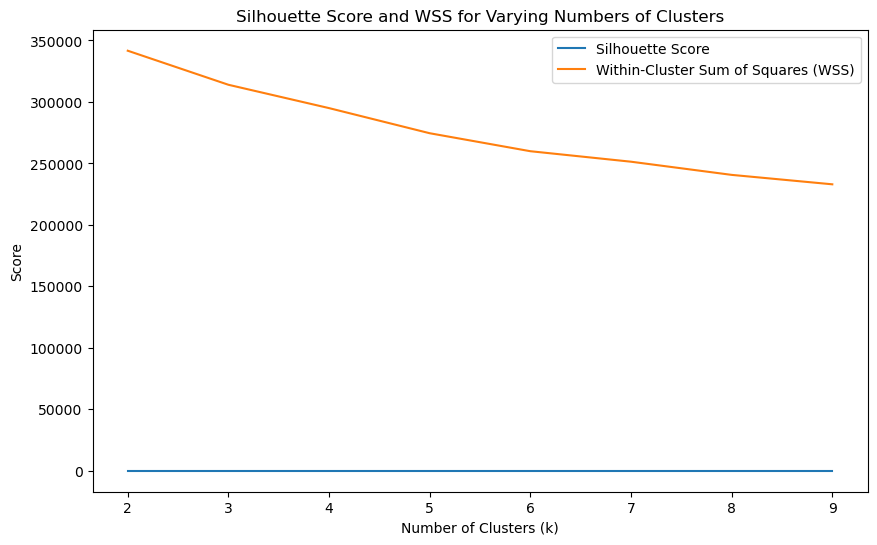

Optimal number of clusters: 2


In [23]:
# Define the number of clusters to try
k_values = range(2, 10)

# Initialize the results
silhouette_scores = []
wss_scores = []

# Execute K-Means for each number of clusters
for k in k_values:
    # Apply K-Means clustering
    centroids, labels = kmeans(X_reduced, k)

    # Calculate the Silhouette score
    silhouette_scores.append(silhouette_score(X_reduced, labels))

    # Calculate the Within-Cluster Sum of Squares (WSS)
    wss_scores.append(np.sum([np.sum(np.linalg.norm(X_reduced[labels == i] - centroids[i], axis=1)**2) for i in range(k)]))

# Plot the scores
plt.figure(figsize=(10, 6))
plt.plot(k_values, silhouette_scores, label='Silhouette Score')
plt.plot(k_values, wss_scores, label='Within-Cluster Sum of Squares (WSS)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.title('Silhouette Score and WSS for Varying Numbers of Clusters')
plt.legend()
plt.show()

# Determine the optimal number of clusters
optimal_k = k_values[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters: {optimal_k}")



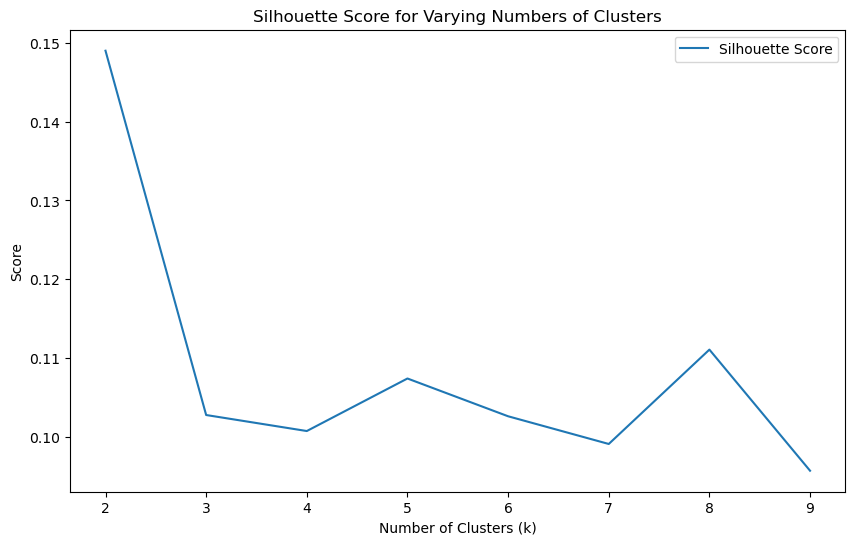

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(2, 10), silhouette_scores, label='Silhouette Score')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Score')
plt.title('Silhouette Score for Varying Numbers of Clusters')
plt.legend()
plt.show()

# Checking Output

To see how good was our clustering we will use a sample check and t-SNE method.

first randomly select two song from every cluster and see how close these two songs are.

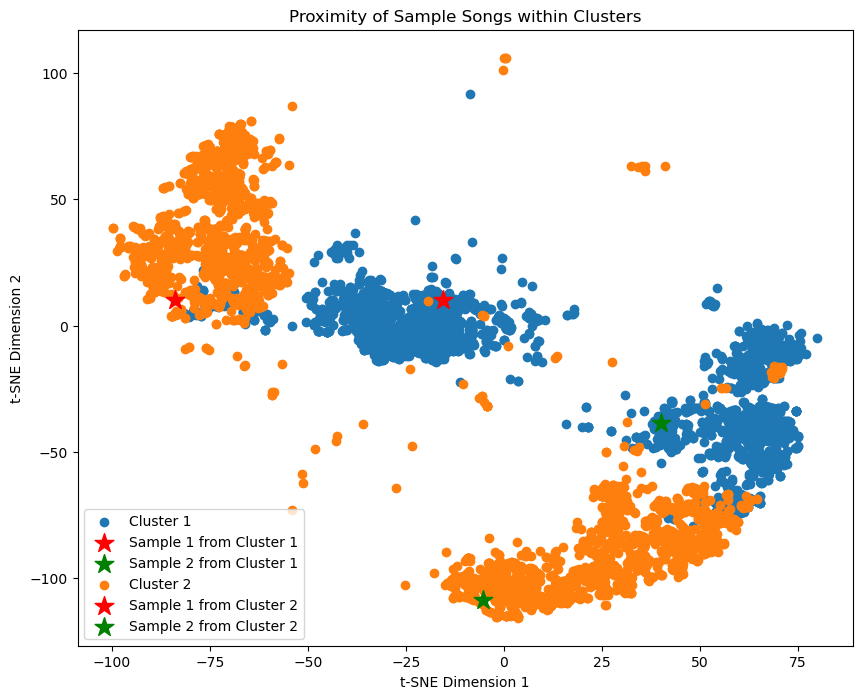

In [26]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Perform t-SNE on the reduced data
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_reduced)

# Randomly select two songs from each cluster
np.random.seed(42)  # Set a seed for reproducibility
sample_songs = []
for i in range(optimal_k):
    cluster_songs = X_reduced[labels == i]
    sample_songs.append(cluster_songs[np.random.choice(len(cluster_songs), size=2, replace=False)])

# Visualize the sample songs using t-SNE
plt.figure(figsize=(10, 8))
for i, songs in enumerate(sample_songs):
    plt.scatter(X_tsne[labels == i, 0], X_tsne[labels == i, 1], label=f"Cluster {i+1}")
    plt.scatter(X_tsne[labels == i, 0][0], X_tsne[labels == i, 1][0], marker='*', s=200, c='r', label=f"Sample 1 from Cluster {i+1}")
    plt.scatter(X_tsne[labels == i, 0][1], X_tsne[labels == i, 1][1], marker='*', s=200, c='g', label=f"Sample 2 from Cluster {i+1}")

plt.legend()
plt.title("Proximity of Sample Songs within Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()

Using t-SNE reduce dimension of data pointe to 2D and plot it to check how good datapoints are clustered (implementing this part is optional and have extra points)

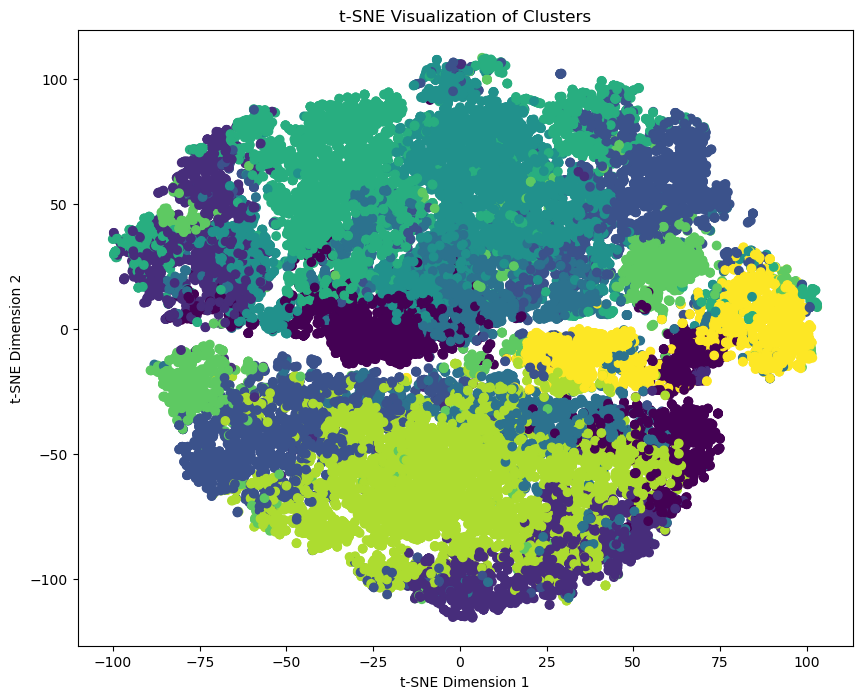

In [27]:

# Perform t-SNE on the reduced data
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_reduced)

# Plot the data points in 2D
plt.figure(figsize=(10, 8))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.title("t-SNE Visualization of Clusters")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.show()